# Determining the age of customers

## Exploratory data analysis

The Bread-Sol supermarket chain is implementing a computer vision system to process customer photos. Photo recording in the checkout area will help determine the age of customers in order to:
Analyze purchases and offer products that may be of interest to buyers of this age group;
Monitor the integrity of cashiers when selling alcohol.
It is necessary to build a model that will determine the approximate age of a person from a photograph. There is a set of photographs of people with an indication of age.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential


In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Sample size:

In [4]:
labels.shape

(7591, 2)

The dataset contains 7591 photographs. 

Age distribution histogram:

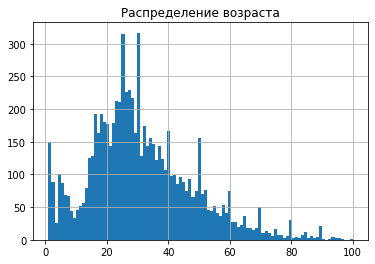

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.hist(bins=100)
plt.title('Age distribution')
plt.show()
labels.describe()

In [7]:
labels["real_age"].head()

0     4
1    18
2    80
3    50
4    17
Name: real_age, dtype: int64

The average age corresponding to the photographs is 31.2 years, with outliers around 1 year and 50, and small outliers around 30,40,60 - that is, many people's ages were rounded to the nearest ten.

Print 10–15 photos on the screen and see how the dataset works.

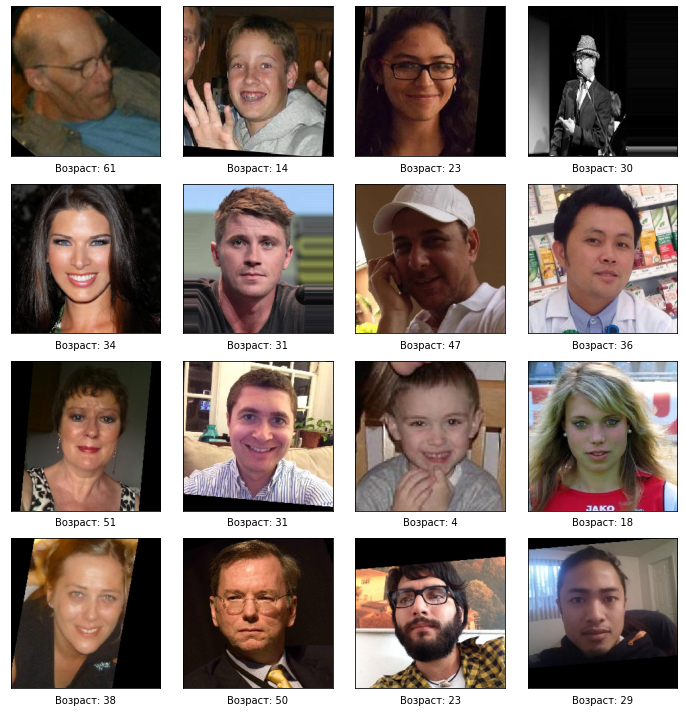

In [22]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])    
    plt.xticks([])
    plt.yticks([])
    plt.text(0.5, -0.1, f'Age: {target[i]}', ha='center', transform=ax.transAxes)
  
    plt.tight_layout()
   

It is clear from the images that the photos are of different quality, angle, lighting, and with foreign objects.

## Model training

A convolutional neural network of the ResNet type was built and trained on a dataset with photographs of people. You need to achieve an MAE value on the test sample of no more than 8.

Training parameters:


The ImageDataGenerator method is used to read data.
Augmentation has also been added.
Convolutional neural network of the ResNet50 type.
Adam is used as an optimizer with a learning step of lr=0.0005.
Number of epochs - 20.

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


logs:

<div class="alert alert-warning">
<h2> <a class="tocSkip"> </h2>
 
```python
    
Логи:  
    Train for 356 steps, validate for 119 steps
Epoch 1/20  
356/356 - 57s - loss: 202.0185 - mae: 10.7840 - val_loss: 429.0938 - val_mae: 15.6850   
Epoch 2/20  
356/356 - 46s - loss: 133.9137 - mae: 8.8774 - val_loss: 369.4225 - val_mae: 14.3813    
Epoch 3/20  
356/356 - 44s - loss: 111.6962 - mae: 8.0672 - val_loss: 117.0243 - val_mae: 8.3135  
Epoch 4/20  
356/356 - 42s - loss: 89.9103 - mae: 7.2126 - val_loss: 133.0213 - val_mae: 8.8165  
Epoch 5/20  
356/356 - 41s - loss: 79.6673 - mae: 6.8353 - val_loss: 102.7041 - val_mae: 7.8087  
Epoch 6/20  
356/356 - 42s - loss: 67.1779 - mae: 6.2537 - val_loss: 111.5816 - val_mae: 8.1108  
Epoch 7/20  
356/356 - 41s - loss: 55.4991 - mae: 5.7371 - val_loss: 105.0525 - val_mae: 7.8710  
Epoch 8/20  
356/356 - 41s - loss: 47.6432 - mae: 5.2832 - val_loss: 126.2806 - val_mae: 8.1949  
Epoch 9/20  
356/356 - 41s - loss: 37.9154 - mae: 4.7360 - val_loss: 103.6467 - val_mae: 7.6359  
Epoch 10/20  
356/356 - 41s - loss: 35.9244 - mae: 4.6271 - val_loss: 83.1346 - val_mae: 6.8881  
Epoch 11/20  
356/356 - 41s - loss: 29.2716 - mae: 4.1657 - val_loss: 115.4525 - val_mae: 7.9066  
Epoch 12/20  
356/356 - 41s - loss: 28.1104 - mae: 4.0655 - val_loss: 142.3808 - val_mae: 9.0800  
Epoch 13/20  
356/356 - 41s - loss: 25.9512 - mae: 3.9188 - val_loss: 84.8277 - val_mae: 7.0583  
Epoch 14/20  
356/356 - 41s - loss: 22.2715 - mae: 3.6464 - val_loss: 84.7796 - val_mae: 6.9977  
Epoch 15/20  
356/356 - 41s - loss: 21.7084 - mae: 3.6021 - val_loss: 111.9522 - val_mae: 7.8865  
Epoch 16/20  
356/356 - 41s - loss: 21.6756 - mae: 3.5704 - val_loss: 104.7051 - val_mae: 7.7053  
Epoch 17/20  
356/356 - 41s - loss: 20.5726 - mae: 3.5094 - val_loss: 79.3429 - val_mae: 6.8124  
Epoch 18/20  
356/356 - 41s - loss: 18.6372 - mae: 3.3411 - val_loss: 99.8940 - val_mae: 7.5544  
Epoch 19/20  
356/356 - 41s - loss: 16.1418 - mae: 3.0782 - val_loss: 85.2797 - val_mae: 7.0272  
Epoch 20/20  
356/356 - 41s - loss: 15.8687 - mae: 3.0775 - val_loss: 80.3229 - val_mae: 6.7334  

119/119 - 10s - loss: 80.3229 - mae: 6.7334
Test MAE: 6.7334
```    

MAE on the test sample reached 6.73, which satisfies the conditions of the problem.

## Analysis of the trained model

A dataset was obtained from photographs of people in order to determine age. During the initial analysis, it was revealed that the photographs were “heterogeneous”, of different quality, angles, etc. Also, age rounding to tens may have been carried out (in the area of emissions). To load the data, the ImageDataGenerator method was used, then a convolutional neural network of the ResNet50 type was built and trained. The 'imagenet' dataset was used to initialize the weights. The MAE value of 6.77 years was achieved on the test sample.


This model is recommended for use in a service that analyzes purchases and offers products that may be of interest to buyers in the analysis age group. The model is not recommended for monitoring the integrity of cashiers when selling alcohol.